# SO(5) Richardson Gaudin

First, let's import the functions and packages we need we need

In [1]:
from solve_rg_eqs import solve_rgEqs, solve_rgEqs_2, G_to_g
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

Setting physical parameters. 

Note that $g$ is not $GL$, but instead
$g = \frac{G}{1-G\sum_k k}$. At $G_c = \frac{1}{\sum_k k}$, $g$ becomes singular. So, around this point I switch to using $1/g$ in the code.

Due to assumptions in the code, I currently require Nup and Ndown to be even numbers.

In [2]:
L = 4 # Very small system, just an illustration
Nup = 2
Ndown = 2

N = Nup + Ndown

dims = (L, Nup, Ndown)

# G_final = 1.5*(2/(np.pi*L)) # 1.5 times critical coupling?
G_final = -0.5
k = np.arange(1, 2*L+1, 2)*0.5*np.pi/L

Setting numerical parameters. If the following things don't work, try decreasing ``dg`` (which will change the other parameters as well). If you want more (or less) points in the output, decrease (increase) the value of ``skip``, which sets how often we remove artificial imaginary parts and save values to output (i.e. skip ``skip`` values of ``g`` before doing this).

In [3]:
dg = 0.01/N # step size of g. Scaling with N instead of L because increasing N increases difficulty
g0 = .01*dg # initial value of g
imk = dg # scale of the imaginary parts added to k
imv = .01*g0 # scale of the imaginary parts used in the initial guess

skip=4*N # it's harder for larger N, so let's make it easy on us

Solving the Richardson-Gaudin equations.

Watch out, this could take a while. It will increment ``g`` from ``g0`` until
it has trouble converging, at which point it switches to incrementing ``1/g``.

Also, ignore things that look like error messages. 

## Wait for the evaluation to complete!
## The [*]: to the left of this should turn into a number [x]:

In [4]:
if G_final > 1./np.sum(k):
    # Need to use different code to pass the critical point
    output_df = solve_rgEqs_2(dims, G_final, k, dg=dg, g0=g0, imscale_k=imk,
                              imscale_v=imv, skip=skip)
else:
    # Can just increment g
    output_df = solve_rgEqs(dims, G_final, k, dg=dg, g0=g0, imscale_k=imk,
                            imscale_v=imv, skip=1)

Initial guesses:
[0.39269523+0.00249999j 0.39269523+0.00249996j]
[0.3926978+0.00249919j 0.3926978+0.00250079j]
First, boostrapping from 4 to 4 fermions

Now using 4 fermions

Bad initial guess. Trying with noise.
g = -2.4996073625936408e-05, er = 0.001821039558532839
1th try at g = -2.4996073625936408e-05
Smallest error from last set: 0.001821039558532839
Noise ranges from -1.4260159458457858e-07 to 8.240427666199163e-08
3th try at g = -2.4996073625936408e-05
Smallest error from last set: 0.0013347113967878983
Noise ranges from -2.2214830342488856e-07 to 2.463785018780053e-07
Error with 4 fermions: 1.727634924425319e-11
Removing im(k) at g = -0.002497617205164472
Variables after removing im(k)
[0.39294248+5.25864476e-21j 0.393609  +7.90978899e-20j]
[0.39327536-0.00019241j 0.39327536+0.00019241j]
Stored values at -0.002497617205164472
Removing im(k) at g = -0.004894573013680872
Variables after removing im(k)
[0.3931746 -4.41550212e-21j 0.39447959+6.19007714e-20j]
[0.39382565-0.00037672j

OK, that took a while. If there's a big pink error message about division by zero, ignore it for now.

If you see an error that says something about child processes, I suggest restarting the kernel and rerunning.

Let's look at the output, stored in a Pandas DataFrame.

To store it as a CSV, uncomment lines 2 and 3 below and input a filename when prompted. Line 4 is an example of how to load the data (or other CSV data) into a Pandas dataframe.

In [5]:
print(output_df)
# filename = input('Name to save file to: ')
# output_df.to_csv(filename)
# new_df = pd.load_csv(filename)

            g         G   Re(e_0)       Im(e_0)  Re(omega_0)  Im(omega_0)  \
0   -0.002498 -0.002537  0.392942  5.258645e-21     0.393275    -0.000192   
1   -0.004895 -0.005050  0.393175 -4.415502e-21     0.393826    -0.000377   
2   -0.007219 -0.007562  0.393398 -3.478418e-20     0.394357    -0.000555   
3   -0.009475 -0.010075  0.393614  2.232570e-21     0.394870    -0.000728   
4   -0.011665 -0.012587  0.393822  3.341323e-20     0.395365    -0.000895   
..        ...       ...       ...           ...          ...          ...   
194 -0.120132 -0.489950  0.402748  3.937967e-19     0.416991    -0.008621   
195 -0.120282 -0.492463  0.402758 -3.463917e-19     0.417017    -0.008631   
196 -0.120431 -0.494975  0.402769 -4.528553e-19     0.417043    -0.008640   
197 -0.120579 -0.497488  0.402779  1.257597e-19     0.417069    -0.008650   
198 -0.120727 -0.500000  0.402790  1.023326e-19     0.417094    -0.008660   

      Re(e_1)       Im(e_1)  Re(omega_1)  Im(omega_1)     energy       R_0 

# Using the results

## Pairons

Let's make a plot of the pairons. First, we need to get the results from the DataFrame. In output_df, the results for each pairon's real and imaginary part is stored as a row, with a name like ``Re(omega_0)``. To get one row, we can do as follows:

In [6]:
output_df['Re(e_0)']

0      0.392942
1      0.393175
2      0.393398
3      0.393614
4      0.393822
         ...   
194    0.402748
195    0.402758
196    0.402769
197    0.402779
198    0.402790
Name: Re(e_0), Length: 199, dtype: float64

I don't want to do this for every column I'm interested in. Let's make lists of these column names:

In [7]:
real_e_index = ['Re(e_{})'.format(i) for i in range(Nup)]
im_e_index = ['Im(e_{})'.format(i) for i in range(Nup)]
real_w_index = ['Re(omega_{})'.format(i) for i in range(Ndown)]
im_w_index = ['Im(omega_{})'.format(i) for i in range(Ndown)]

# Is this the thing we wanted?
print(real_e_index)
print(im_e_index)
print(real_w_index)
print(im_w_index)

['Re(e_0)', 'Re(e_1)']
['Im(e_0)', 'Im(e_1)']
['Re(omega_0)', 'Re(omega_1)']
['Im(omega_0)', 'Im(omega_1)']


Let's make a plot with labels and titles and legends!

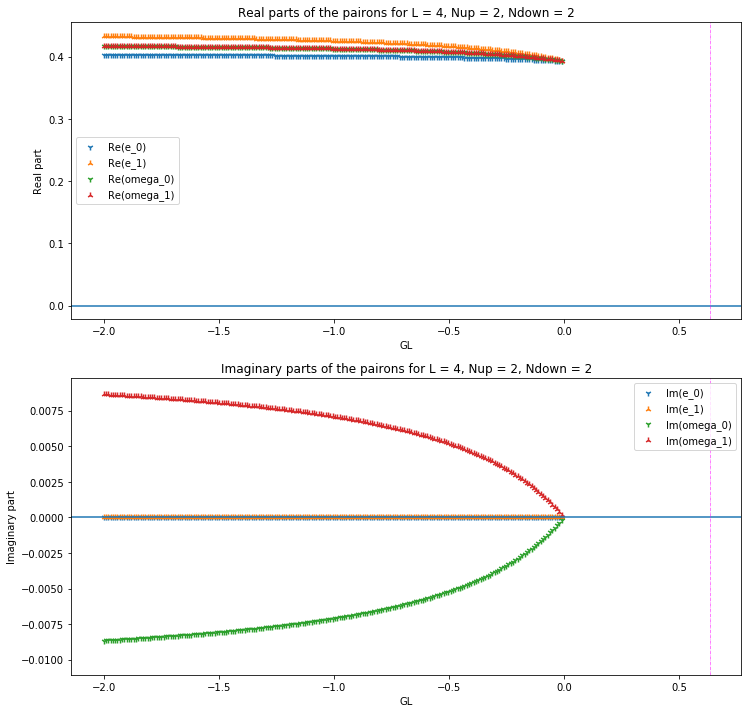

In [8]:
plt.figure(figsize=(12,12)) # Making a bigger figure for the plots

markers = ['1', '2', '3', '4', 'x', '+', '.', 'v', '^'] 
# using different shapes for the markers so we can see stacked results

plt.subplot(2,1,1) # Making 2 subplots, first for real parts
for i, ind in enumerate(real_e_index):
    # Plotting like before, but now assigning labels for the legend
    # Luckily, our rownames are decent labels already
    plt.scatter(output_df['G']*L, output_df[ind], label=ind, marker=markers[i]) 
# Doing the same for real parts of omega
for i, ind in enumerate(real_w_index): 
    plt.scatter(output_df['G']*L, output_df[ind], label=ind, marker=markers[i]) 

# Let's plot a horizontal line at 0
plt.axhline(0)

# Let's make a thin, vertical, dotted/dashed, magenta line at G_c
g_c = L/np.sum(k)
plt.axvline(g_c, ls='-.', color='magenta', linewidth=.5)
    
# Making axes labels
plt.title('Real parts of the pairons for L = {}, Nup = {}, Ndown = {}'.format(L, Nup, Ndown))
plt.xlabel('GL')
plt.ylabel('Real part')
plt.legend() 
    
plt.subplot(2,1,2) # Now moving to a second subplot
for i, ind in enumerate(im_e_index):
    plt.scatter(output_df['G']*L, output_df[ind], label=ind, marker=markers[i]) 
for i, ind in enumerate(im_w_index): 
    plt.scatter(output_df['G']*L, output_df[ind], label=ind, marker=markers[i]) 

plt.axhline(0)
plt.axvline(g_c, ls='-.', color='magenta', linewidth=.5)    
    
plt.title('Imaginary parts of the pairons for L = {}, Nup = {}, Ndown = {}'.format(L, Nup, Ndown))
plt.xlabel('GL')
plt.ylabel('Imaginary part')
plt.legend()

plt.show()

We can change the limits of the axes to get a closer look at the behavior around G_c:

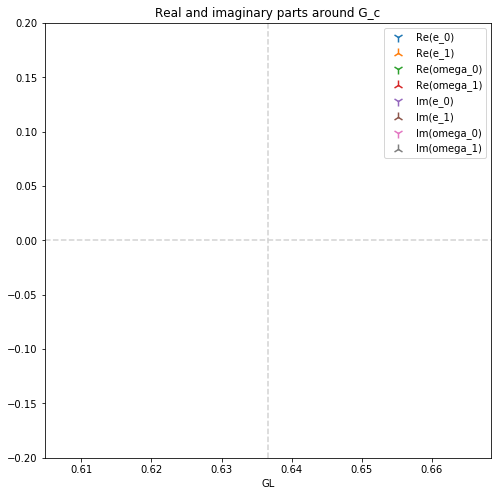

In [10]:
plt.figure(figsize=(8,8))

plt.axvline(g_c, ls = '--', color='lightgray')
plt.axhline(0, ls = '--', color='lightgray')

for i, ind in enumerate(real_e_index):
    # s is the size of the marks (not sure the units)
    # Let's make them bigger!
    plt.scatter(output_df['G']*L, output_df[ind], label=ind, marker=markers[i], s=100) 
for i, ind in enumerate(real_w_index): 
    plt.scatter(output_df['G']*L, output_df[ind], label=ind, marker=markers[i], s=100) 
for i, ind in enumerate(im_e_index):
    plt.scatter(output_df['G']*L, output_df[ind], label=ind, marker=markers[i], s=100) 
for i, ind in enumerate(im_w_index): 
    plt.scatter(output_df['G']*L, output_df[ind], label=ind, marker=markers[i], s=100) 
    
plt.xlim(0.95*g_c, 1.05*g_c) # Looking within 5% of g_c
plt.ylim(-0.2, 0.2) # You might need to change these values

plt.legend()
plt.xlabel('GL')

plt.title('Real and imaginary parts around G_c')
plt.show()

## Energy
We can also plot energy (and other things). Let's get the energy and derivatives from the output DataFrame.

Again, if there is a division by zero error, ignore it for now. This occurs if we are taking the derivative of something too close to vertical.

In [12]:
Es = output_df['energy']
Gs = output_df['G']
# Rescaling by appropriate factors of L
es = Es/L
gs = Gs*L # different than g in previous plot

print('Taking 1st derivative')
de = np.gradient(es, gs) # derivative de/dg
print('Taking 2nd derivative')
d2e = np.gradient(de, gs) # second derivative
print('Taking 3rd derivative')
d3e = np.gradient(d2e, gs) # third

Taking 1st derivative
Taking 2nd derivative
Taking 3rd derivative


Now, let's make a 2-by-2 plot with the energy and derivatives.

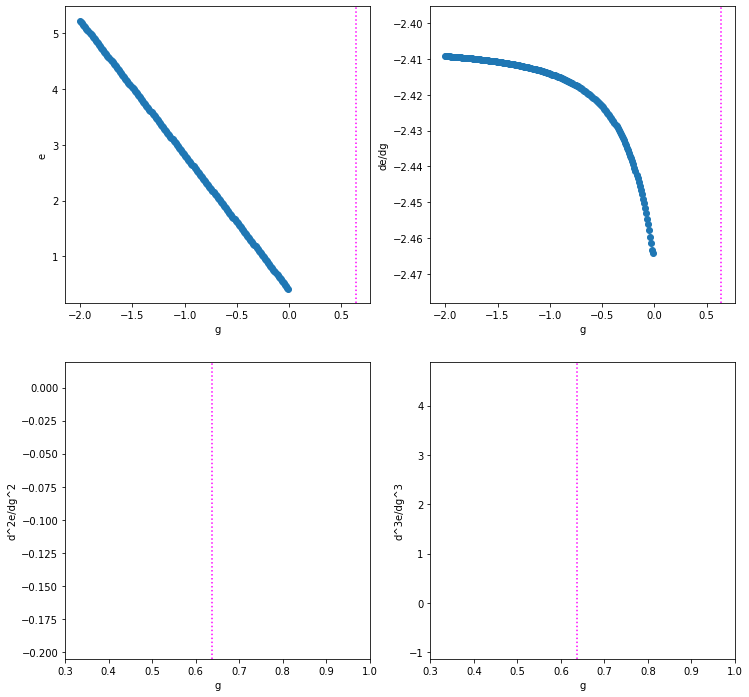

In [13]:
plt.figure(figsize=(12, 12))

plt.subplot(2, 2, 1)
plt.scatter(gs, es)
plt.xlabel('g')
plt.ylabel('e')
plt.axvline(g_c, ls=':', color='magenta')

plt.subplot(2, 2, 2)
plt.scatter(gs, de)
plt.xlabel('g')
plt.ylabel('de/dg')
plt.axvline(g_c, ls=':', color='magenta')


plt.subplot(2, 2, 3)
plt.scatter(gs, d2e)
plt.xlabel('g')
plt.ylabel('d^2e/dg^2')
plt.axvline(g_c, ls=':', color='magenta')
plt.xlim(0.3, 1.0)


plt.subplot(2, 2, 4)
plt.scatter(gs, d3e)
plt.xlabel('g')
plt.ylabel('d^3e/dg^3')
plt.axvline(g_c, ls=':', color='magenta')
plt.xlim(0.3, 1.0) 
# Behavior around G=0 is weird but this is due to truncation and inaccuracies in the solution around that point

plt.show()

## Momentum Distribution

Let's look at the momentum distribution within $5\%$ of my prediction for $G_c$.

No handles with labels found to put in legend.


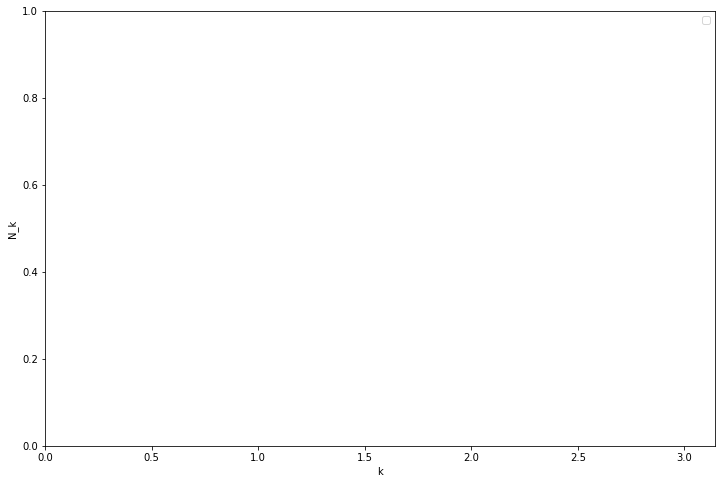

In [14]:
N_inds = ['N_{}'.format(i) for i in range(L)]

plt.figure(figsize=(12, 8))

for i, G in enumerate(Gs):
    if 0.95 < G*L/g_c < 1.05: # Only selecting within 2% of G_c
        plt.plot(k, output_df[N_inds].iloc[i], 
                label='g = {}'.format(np.round(G*L, 3)), # rounding the label to 3 decimal places
                 marker='o') # Putting a dot at each data point
plt.xlabel('k')
plt.ylabel('N_k')
plt.legend()
plt.xlim(0, np.pi)
plt.show()

At precisely the critical coupling, it seems like Jorge's prediction of perfectly flat distribution is true, just not at the coupling he predicted.

To get a better sense of overall behavior, we can plot at a wider range of coupling. To make sure we don't end up with too many lines, I'll only plot once every 5 datapoints.

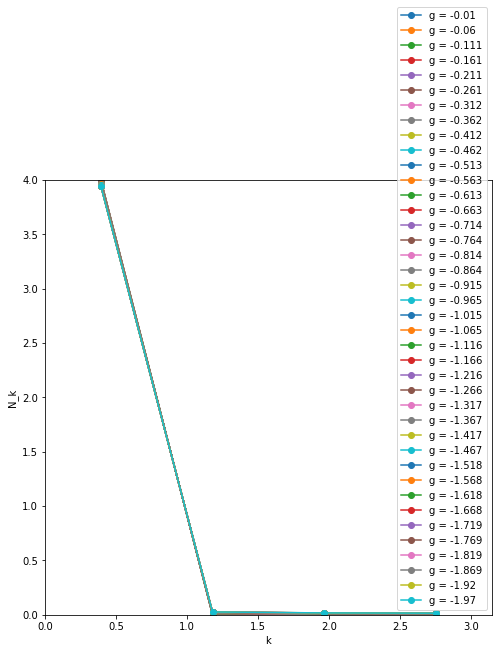

In [15]:
plt.figure(figsize=(8,8))        

for i, G in enumerate(Gs):
    if i%5 == 0: # Only using indices that are multiples of 5
        plt.plot(k, output_df[N_inds].iloc[i], 
                label='g = {}'.format(np.round(G*L, 3)), # rounding the label to 3 decimal places
                 marker='o') # Putting a dot at each data point

plt.xlabel('k')
plt.ylabel('N_k')
plt.legend()
plt.xlim(0, np.pi)
plt.ylim(0, 4) # Limits on values of N_k = n_{k up} + n_{k down} + n_{-k up} + n_{-k down}
plt.show()

# Checking results with exact diagonalization

To use my exact-diagonalization code, you will need the [Quspin package](https://weinbe58.github.io/QuSpin/).
First, we import functions from my exact-diagonalization code and create a basis for ``Nup`` spin up and ``Ndown``
spin down fermions on a 1-d lattice with ``2L`` sites (since ``L`` counts only positive $k$):

In [16]:
from exact_diag import ham_op_2, find_nk, form_basis, casimir_dict, iom_dict, quantum_operator
basis = form_basis(2*L, Nup, Ndown)
print('Number of states in the basis:')
print(basis.Ns)

Number of states in the basis:
784


Now, we create a Hamiltonian (as Quspin ``quantum_operator`` object) corresponding to our final coupling.
Note that if the number of states in the basis is too big, this operator will eat up a lot of memory. I would recommend not running any of this for L > 5.

In [17]:
H = ham_op_2(L, G_final, k, basis=basis)


Hermiticity check passed!
Symmetry checks passed!
Particle conservation check passed!


We can diagonalize this Hamiltonian. Let's do full diagonalization if the dimension of the Hilbert space is
less than 4000, and do sparse diagonalization to only get the 10 lowest-energy states if it's larger than that.

Dimension of the Hilbert space:
784


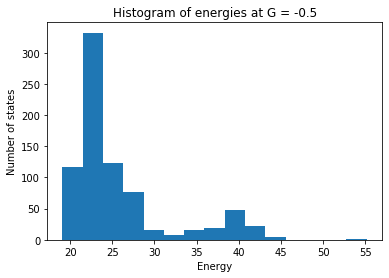

In [18]:
dim_h = basis.Ns
print('Dimension of the Hilbert space:')
print(dim_h)

if dim_h > 4000:
    exact_energies, exact_states = H.eigsh(k=10, which='SA') # k is number of states to find, SA means find the smallest algabraic eigenvalues
else:
    exact_energies, exact_states = H.eigh() # Full diagonalization of a Hermitian matrix
    
# Creating a histogram of the energies
plt.hist(exact_energies, bins=dim_h//50)
plt.xlabel('Energy')
plt.ylabel('Number of states')
plt.title('Histogram of energies at G = {}'.format(G_final))
plt.show()

Let's compare the ground state energy from ED to the final ground state energy from the RG equations:

In [19]:
print('ED ground state energy')
print(exact_energies[0]) 

print('RG ground state energy')
print(output_df['energy'].iloc[-1])

print('Difference')
print(exact_energies[0] - output_df['energy'].iloc[-1])

ED ground state energy
19.082828514842348
RG ground state energy
20.927698011780137
Difference
-1.8448694969377897


Now let's plot the difference between energies at various couplings.

Hermiticity check passed!
Symmetry checks passed!
Particle conservation check passed!
Hermiticity check passed!
Symmetry checks passed!
Particle conservation check passed!
Hermiticity check passed!
Symmetry checks passed!
Particle conservation check passed!
Hermiticity check passed!
Symmetry checks passed!
Particle conservation check passed!
Hermiticity check passed!
Symmetry checks passed!
Particle conservation check passed!
Hermiticity check passed!
Symmetry checks passed!
Particle conservation check passed!
Hermiticity check passed!
Symmetry checks passed!
Particle conservation check passed!
Hermiticity check passed!
Symmetry checks passed!
Particle conservation check passed!
Hermiticity check passed!
Symmetry checks passed!
Particle conservation check passed!
Hermiticity check passed!
Symmetry checks passed!
Particle conservation check passed!
Hermiticity check passed!
Symmetry checks passed!
Particle conservation check passed!
Hermiticity check passed!
Symmetry checks passed!
Part

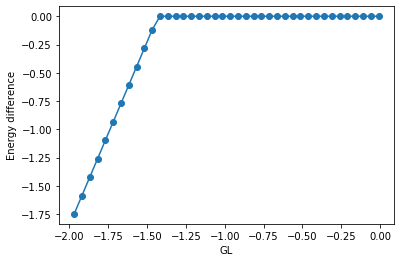

In [20]:
diffs = []
divisible_Gs = []
for i, G in enumerate(Gs):
    if i%20 == 0: # Only using indices that are multiples of 15
        h = ham_op_2(L, G, k, basis=basis)
        e, v = h.eigsh(k=1, which = 'SA') # we only need the 0th energy
        diffs += [e[0] - output_df['energy'].iloc[i]]
        divisible_Gs += [G]
         
plt.plot(np.array(divisible_Gs)*L, diffs, marker='o')
plt.xlabel('GL')
plt.ylabel('Energy difference')
# plt.ylim(-10**-12, 10**-12)
plt.show()

## Charge gap/chemical potential
Let's define some more quantities: First, chemical potential is (more or less) the energy
required to add a fermion to the system. We can estimate it as
\begin{equation}
\mu = \frac{E(N+1)- E(N) + E(N) - E(N-1)}{2}
= \frac{E(N+1) -E(N-1)}{2}
\end{equation}
where $E(M)$ is the ground state energy with $M$ fermions.

We can define a similar quantity, the charge gap (which I will call $\Delta$):
\begin{equation}
\Delta  = \frac{E(N+1) + E(N-1) - 2 E(N)}{2}.
\end{equation}

Let's see how these behave around our critical point:

In [51]:
Gss = np.linspace(0, G_final, 20)

b_plus = form_basis(2*L, Nup + 1, Ndown)
b_minus = form_basis(2*L, Nup - 1, Ndown)
e_plus = np.zeros(len(Gss))
energies = np.zeros(len(Gss))
e_minus = np.zeros(len(Gss))
for i, G in enumerate(Gss):
    h_plus = ham_op_2(L, G, k, basis=b_plus)
    h = ham_op_2(L, G, k, basis=basis)
    h_minus = ham_op_2(L, G, k, basis=b_minus)
    ep, vp = h_plus.eigsh(k=1, which='SA')
    e, v = h.eigsh(k=1, which='SA')
    em, vm = h_minus.eigsh(k=1, which='SA')
    e_plus[i] = ep[0]
    energies[i] = e[0]
    e_minus[i] = em[0]

Hermiticity check passed!
Symmetry checks passed!
Particle conservation check passed!
Hermiticity check passed!
Symmetry checks passed!
Particle conservation check passed!
Hermiticity check passed!
Symmetry checks passed!
Particle conservation check passed!
Hermiticity check passed!
Symmetry checks passed!
Particle conservation check passed!
Hermiticity check passed!
Symmetry checks passed!
Particle conservation check passed!
Hermiticity check passed!
Symmetry checks passed!
Particle conservation check passed!
Hermiticity check passed!
Symmetry checks passed!
Particle conservation check passed!
Hermiticity check passed!
Symmetry checks passed!
Particle conservation check passed!
Hermiticity check passed!
Symmetry checks passed!
Particle conservation check passed!
Hermiticity check passed!
Symmetry checks passed!
Particle conservation check passed!
Hermiticity check passed!
Symmetry checks passed!
Particle conservation check passed!
Hermiticity check passed!
Symmetry checks passed!
Part

In [21]:
mu = (e_plus - e_minus)/2
cg = (e_plus + e_minus - 2*energies)/2
plt.figure(figsize=(8,8))
plt.axhline(0, color='gray')
plt.axvline(g_c, color='gray')
plt.plot(Gss*L, mu/L, label = '$\mu/L$', marker = '+')
plt.plot(Gss*L, cg/L, label = '$\Delta/L$', marker = 'o')
plt.xlabel('GL')
plt.title('Chemical potential and charge gap')
plt.legend()
plt.show()

NameError: name 'e_plus' is not defined